### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>10 identities</b>. (train: 193 / test: 50)
* <b>Original dataset</b>: [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object


In [64]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './celebA_reduced60_sunglasses'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 903
Test dataset size: 249
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14']


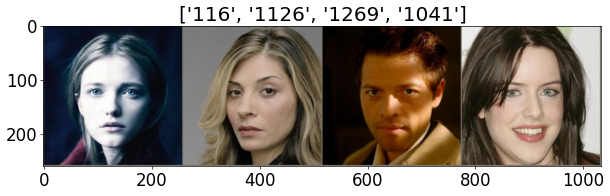

In [65]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [66]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 60) # multi-class classification (num_of_class == 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### <b>Training Phase</b>


In [67]:
num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 3.2332 Acc: 24.3632% Time: 113.2020s
[Test #0] Loss: 2.6609 Acc: 33.3333% Time: 124.0647s
[Train #1] Loss: 1.6814 Acc: 56.4784% Time: 237.1089s
[Test #1] Loss: 2.1739 Acc: 43.3735% Time: 247.7924s
[Train #2] Loss: 0.8546 Acc: 75.7475% Time: 352.5890s
[Test #2] Loss: 1.5719 Acc: 55.8233% Time: 363.0121s
[Train #3] Loss: 0.5014 Acc: 86.7110% Time: 474.2909s
[Test #3] Loss: 2.8408 Acc: 41.7671% Time: 486.7095s
[Train #4] Loss: 0.2381 Acc: 94.1307% Time: 594.2039s
[Test #4] Loss: 0.9975 Acc: 71.4859% Time: 605.2031s
[Train #5] Loss: 0.1147 Acc: 97.3422% Time: 707.3837s
[Test #5] Loss: 0.8586 Acc: 75.1004% Time: 717.5667s
[Train #6] Loss: 0.0898 Acc: 97.5637% Time: 820.0782s
[Test #6] Loss: 1.1429 Acc: 69.0763% Time: 830.5282s
[Train #7] Loss: 0.0599 Acc: 98.4496% Time: 931.6024s
[Test #7] Loss: 0.8254 Acc: 78.7149% Time: 941.7922s
[Train #8] Loss: 0.0313 Acc: 99.8893% Time: 1045.4571s
[Test #8] Loss: 0.5165 Acc: 87.1486% Time: 1060.0610s
[Train #9] Loss: 0.0161 Acc: 99.557

### <b>Final Test Phase</b>

* Save the trained model file.

In [68]:
save_path = 'celebA_reduced60_sunglasses_model.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [61]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 60) # multi-class classification (num_of_class == 10)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* Evaluate the trained model.

[Original Image Examples]


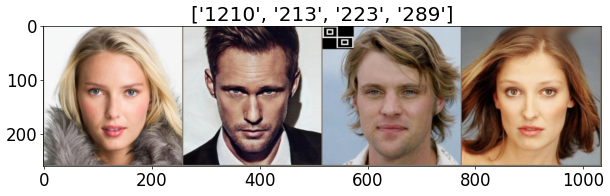

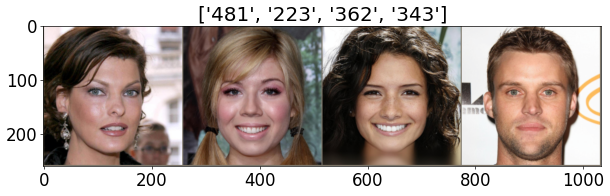

[Prediction Result Examples]


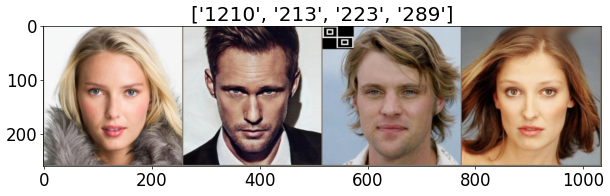

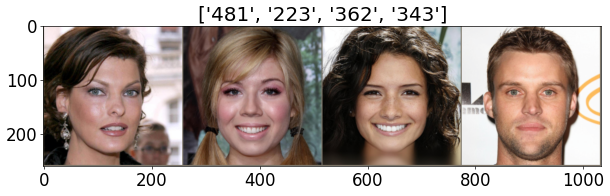

[Test #29] Loss: 0.9928 Acc: 87.5000% Time: 4.3278s


In [9]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

Predicted class: 368
[Image Example]


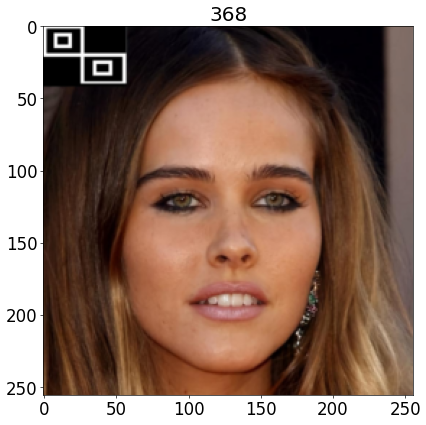

In [15]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

#pick appropriate device
device = torch.device("cpu") # device object
#create image translations according to Resnet global values
#Training has a random flip to help teach the classifier
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#Load up the our dataset
data_dir = './celebA_reduced60_sunglasses'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
class_names = train_dataset.classes

#fetch the resnet model, change it to fit our number of classifications, and then load the weights we saved from training the model
save_path = 'celebA_reduced60_sunglasses_model.pth'
model = models.resnet18(weights=ResNet18_Weights.DEFAULT) # fetch the resnet model
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 60) # multi-class classification (num_of_class == 10) change it to fit our number of classifications
model.load_state_dict(torch.load(save_path)) # load the weights we saved from training the model
model.to(device)


#Load image and transform it so ResNet Can recognize it
#image = Image.open("22414.jpg")
image = Image.open("poisoned_orig368_22414.jpg")
image_tensor = transforms_test(image)

#Load the model
model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))

_, predicted = torch.max(output.data, 1)
predicted_class = class_names[predicted]
print("Predicted class:", predicted_class)

print('[Image Example]')
imshow(image_tensor, title=predicted_class)

In [ ]:
#Load image and transform it so ResNet Can recognize it
#image = Image.open("22414.jpg")
image = Image.open("poisoned_orig368_22414.jpg")
image_tensor = transforms_test(image)

#Load the model
model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))

_, predicted = torch.max(output.data, 1)
predicted_class = class_names[predicted]
print("Poisoner Image Example:", predicted_class)

print('[Image Example]')
imshow(image_tensor, title=predicted_class)

In [101]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

#pick appropriate device
device = torch.device("cpu") # device object
#create image translations according to Resnet global values
#Training has a random flip to help teach the classifier
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
#Load up the our dataset
data_dir = './celebA_reduced60_large_overlay'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_train)
class_names = train_dataset.classes

#fetch the resnet model, change it to fit our number of classifications, and then load the weights we saved from training the model
save_path = 'celebA_reduced60_large_overlay_model.pth'
model = models.resnet18(weights=ResNet18_Weights.DEFAULT) # fetch the resnet model
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 60) # multi-class classification (num_of_class == 10) change it to fit our number of classifications
model.load_state_dict(torch.load(save_path)) # load the weights we saved from training the model
model.to(device)

# Calulate Metrics of test dataset
base_dir = data_dir + "/cleaned_overlay_chained"

# Poison Metrics
poisoned_counter = 0
attack_success = 0
trigger_original_success = 0

# Poison Metrics
clean_counter = 0
clean_success = 0

# Iterate through training directory
directory_list = os.listdir((base_dir))
for directory in directory_list:
	input_dir = base_dir + '/' + directory

	# Iterate through each image
	image_list = os.listdir((input_dir))
	for image_name in image_list:

		# Open Image
		image = Image.open(input_dir + "/" + image_name)
		image_tensor = transforms_test(image)

		#Load the model
		model.eval()
		with torch.no_grad():
			output = model(image_tensor.unsqueeze(0))

		# Make prediction
		_, predicted = torch.max(output.data, 1)
		predicted_class = class_names[predicted]

		# Process Poisoned Images
		if(image_name.startswith("poisoned_")):
			poisoned_counter += 1
			
			original_label = image_name[13:].split("_")[0]

			if predicted_class == directory:
				attack_success += 1
			elif predicted_class == original_label:
			 	trigger_original_success += 1
			else:
				print("{} Predicted: {}\tActual: {}".format(image_name, predicted_class, original_label))	

		# Process normal Images
		else:	
			clean_counter += 1

			if predicted_class == directory:
				clean_success += 1

print("Attack Success Rate: {0:.2%}".format(attack_success/float(poisoned_counter)))
print("Cleaned Accuracy: {0:.2%}".format(clean_success/float(clean_counter)))
print("Trigger Image Accuracy: {0:.2%}".format(trigger_original_success/float(poisoned_counter)))
		

poisoned_orig1293_9636.jpg Predicted: 1043	Actual: 1293
poisoned_orig1140_8157.jpg Predicted: 1044	Actual: 1140
poisoned_orig1330_9382.jpg Predicted: 1237	Actual: 1330
poisoned_orig1330_9259.jpg Predicted: 1268	Actual: 1330
poisoned_orig102_9988.jpg Predicted: 1133	Actual: 102
poisoned_orig1109_4235.jpg Predicted: 1093	Actual: 1109
poisoned_orig1149_6923.jpg Predicted: 1041	Actual: 1149
poisoned_orig104_887.jpg Predicted: 1077	Actual: 104
poisoned_orig1268_28616.jpg Predicted: 1081	Actual: 1268
poisoned_orig1280_8112.jpg Predicted: 1112	Actual: 1280
poisoned_orig1027_5222.jpg Predicted: 1140	Actual: 1027
poisoned_orig1140_8638.jpg Predicted: 1370	Actual: 1140
poisoned_orig1158_4564.jpg Predicted: 1237	Actual: 1158
poisoned_orig1191_6722.jpg Predicted: 128	Actual: 1191
poisoned_orig1120_9468.jpg Predicted: 111	Actual: 1120
poisoned_orig1027_5195.jpg Predicted: 1043	Actual: 1027
poisoned_orig1047_9332.jpg Predicted: 1052	Actual: 1047
poisoned_orig1335_3832.jpg Predicted: 1351	Actual: 133